### UMAP Encodding

In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
%matplotlib inline

In [2]:
print(umap.__version__)

0.4.6


In [ ]:
#conda install -c conda-forge lightgbm

In [ ]:
#conda install -c conda-forge shap

In [5]:
full_data = pd.read_csv("./SSBCI Drop Cols.csv")
full_data.drop(labels="Unnamed: 0", axis=1,inplace=True)
full_data.isna().sum()
full_data.head()

,state_id,state_name,year_reported,program_name,program_type,unique_id,disbursement_date,loan_investment_amount,ssbci_original_funds,nonprivate_amount,...,zip_code,metro_type,LMI_type,revenue,full_time_employees,naics_code,year_incorporated,jobs_created,jobs_retained,trans_type
0,AK,Alaska - Anchorage,2013,49th State Venture Fund,Venture Capital,AK_2013_VCP_1,3/1/2013,180000.0,90000.0,0.0,...,99507,Metro,Non-LMI,0.0,5.0,541511,2013,3.0,1.0,VC
1,AK,Alaska - Anchorage,2013,49th State Venture Fund,Venture Capital,AK_2013_VCP_2,7/13/2013,2400000.0,250000.0,0.0,...,99501,Metro,LMI,0.0,28.0,423930,2012,4.0,0.0,VC
2,AK,Alaska - Anchorage,2013,49th State Venture Fund,Venture Capital,AK_2013_VCP_3,12/30/2013,265000.0,110000.0,0.0,...,99507,Metro,Non-LMI,0.0,7.0,541511,2013,2.0,5.0,VC
3,AK,Alaska - Anchorage,2014,49th State Venture Fund,Venture Capital,AK_2014_VCP_1,4/11/2014,199500.0,99750.0,0.0,...,99501,Metro,Non-LMI,0.0,2.0,336612,2014,8.0,0.0,VC
4,AK,Alaska - Anchorage,2014,49th State Venture Fund,Venture Capital,AK_2014_VCP_2,5/15/2014,125000.0,62500.0,0.0,...,99503,Metro,LMI,1494916.0,8.0,451110,2007,8.0,0.0,VC


In [6]:
full_data.dtypes

state_id                         object
state_name                       object
year_reported                     int64
program_name                     object
program_type                     object
unique_id                        object
disbursement_date                object
loan_investment_amount          float64
ssbci_original_funds            float64
nonprivate_amount               float64
concurrent_private_financing    float64
borrower_insurance_premium      float64
lender_insurance_premium        float64
guaranteed_amount               float64
collateral_support              float64
ssbci_recycled_funds            float64
subsequent_private_financing    float64
zip_code                          int64
metro_type                       object
LMI_type                         object
revenue                         float64
full_time_employees             float64
naics_code                        int64
year_incorporated                 int64
jobs_created                    float64


In [7]:
cols = full_data.columns
#[full_data.columns.get_loc(c) for c in cols if c.dtype == 'oject' ]
cat_features=[full_data.columns.get_loc(c) for c in full_data.columns if full_data.dtypes[c]=='object']
cat_features

[0, 1, 3, 4, 5, 6, 18, 19, 26]

Before going to clustering, there’s one extra step to do. One of the comparison methods will be visual, so we need a way to visualise the quality of clustering. I’ll be using <a href="https://umap-learn.readthedocs.io/en/latest/"> Uniform Manifold Approximation and Projection for Dimension Reduction (UMAP)</a> - a dimensionality reduction technique (like PCA or t-SNE) - to embedd the data into 2 dimensions. This will allow me to visually see the groups of customers, and how well did the clustering algorithms do the job. There are 3 steps to get the proper embeddings:

Yeo-Johnson transform the numerical columns & One-Hot-Encode the categorical data
Embed these two column types separately
Combine the two by conditioning the numerical embeddings on the categorical embeddings as suggested <a href=https://github.com/lmcinnes/umap/issues/58#issuecomment-419682509> here </a>

/Users/lenmancini/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2947: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda
/Users/lenmancini/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/lenmancini/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/Users/lenmancini/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/lenmancini/opt/anaconda3/lib/python3.7/site-pac

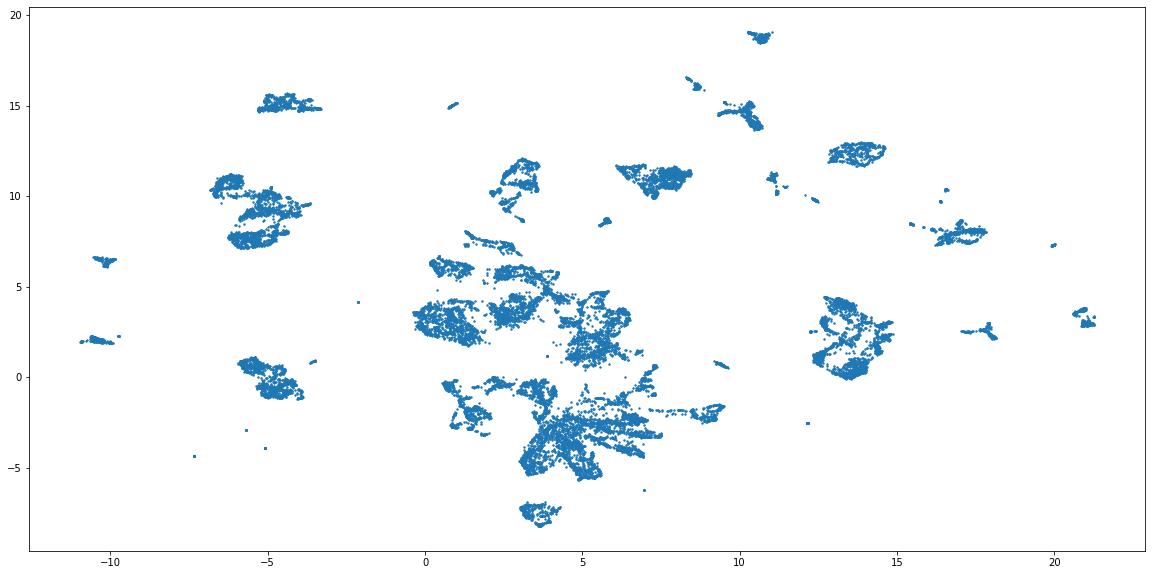

In [8]:
#Preprocessing numerical
from sklearn.preprocessing import PowerTransformer


numerical = full_data.select_dtypes(exclude='object')

for c in numerical.columns:
    pt = PowerTransformer()
    numerical.loc[:, c] = pt.fit_transform(np.array(numerical[c]).reshape(-1, 1))
    
##preprocessing categorical
categorical = full_data.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(full_data.select_dtypes(include='object').columns) / full_data.shape[1]

#Embedding numerical & categorical
fit1 = umap.UMAP(metric='l2').fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)

#Augmenting the numerical embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight,)
intersection = umap.umap_.reset_local_connectivity(intersection)
#embedding = umap.UMAP(n_neighbors=5).fit_transform(data)
embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False)

plt.figure(figsize=(20, 10))
#print(*embedding)
plt.scatter(*embedding.T, s=2, cmap='Spectral', alpha=1.0)
plt.show()

### K Means

Because K-Means only works with numerical data, I’ll:

<li>One-Hot-Encode the categorical data
<li>Apply the Yeo-Johnson transformation to the data to make it more Gaussian like
<li>Fit K-Means with 15 clusters

In [9]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from datetime import datetime 
from tqdm import tqdm
from sklearn.preprocessing import PowerTransformer
import umap
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy import stats

from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes


from lightgbm import LGBMClassifier
import shap
from sklearn.model_selection import cross_val_score


/Users/lenmancini/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [ ]:
#One-Hot-Encoding
data = pd.get_dummies(full_data)

#Pre-processing
for c in data.columns:
    pt = PowerTransformer()
    data.loc[:, c] = pt.fit_transform(np.array(data[c]).reshape(-1, 1))

In [ ]:
#Actual Clustering
kmeans = KMeans(n_clusters=15).fit(data)
kmeans_labels = kmeans.labels_
pd.Series(kmeans_labels).value_counts()

In [ ]:
#OPTIONAL: Elbow plot with inertia
#Elbow method to choose the optimal number of clusters
sse = {}
for k in tqdm(range(2, 50)):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    
fig = go.Figure(data=go.Scatter(x=list(sse.keys()), y=list(sse.values())))
fig.show()

### K Prototypes

In [10]:
kprot_data = full_data.copy()
#Pre-processing
for c in full_data.select_dtypes(exclude='object').columns:
    pt = PowerTransformer()
    kprot_data[c] =  pt.fit_transform(np.array(kprot_data[c]).reshape(-1, 1))

categorical_columns = cat_features #make sure to specify correct indices

/Users/lenmancini/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2947: RuntimeWarning: overflow encountered in power
  out[pos] = (np.power(x[pos] + 1, lmbda) - 1) / lmbda
/Users/lenmancini/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/lenmancini/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)
/Users/lenmancini/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/Users/lenmancini/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


In [17]:
#Actual clustering
kproto = KPrototypes(n_clusters= 10, init='Cao', n_jobs = 4)
clusters = kproto.fit_predict(kprot_data, categorical=categorical_columns)

#Prints the count of each cluster group
pd.Series(clusters).value_counts()

1    6590
6    3122
7    2245
4    1995
9    1944
3    1623
0    1311
5    1082
2    1073
8     977
dtype: int64

In [ ]:
#OPTIONAL: Elbow plot with cost (will take a LONG time)
costs = []
n_clusters = []
clusters_assigned = []

for i in tqdm(range(2, 25)):
    try:
        kproto = KPrototypes(n_clusters= i, init='Cao', verbose=1)
        clusters = kproto.fit_predict(kprot_data, categorical=cat_features)
        costs.append(kproto.cost_)
        n_clusters.append(i)
        clusters_assigned.append(clusters)
    except:
        print(f"Can't cluster with {i} clusters")
        
fig = go.Figure(data=go.Scatter(x=n_clusters, y=costs ))
fig.show()

### Visual Evaluation

### K Means

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], s=2, c=kmeans_labels, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=15),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

### K Prototypes

In [ ]:
embedding[:,0]

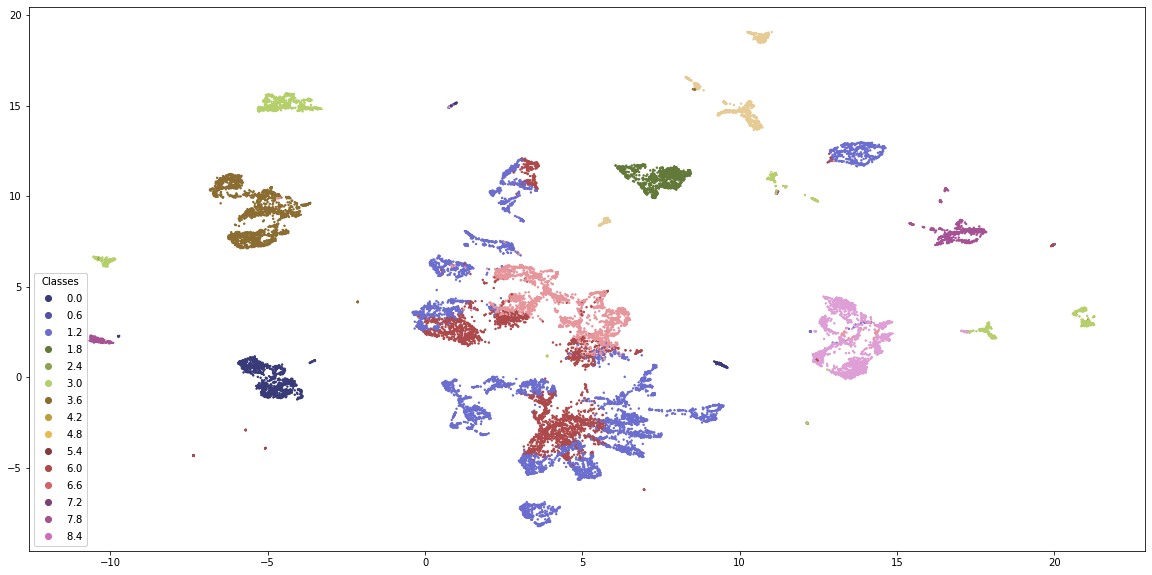

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], s=2, c=clusters, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=15),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

## Evaluation of Classification

Another comparison that I’m going to do is by treating the clusters as labels and building a classification model on top. If the clusters are of high quality, the classification model will be able to predict them with high accuracy. At the same time, the models should use a variety of features to ensure that the clusters are not too simplistic. Overall, I’ll check the following attributes:
<ul>
<li>Distinctivness of clusters by cross-validated F1 score
<li>Informativness of clusters by SHAP feature importances
</ul>
I will use LightGBM as my classifier because it can use categorical features and you can easily get the SHAP values for the trained models.

### K Means

In [14]:
#Setting the objects to category 
lgbm_data = full_data.copy()
for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')

In [ ]:
#KMeans clusters
clf_km = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_km = cross_val_score(clf_km, lgbm_data, kmeans_labels, scoring='f1_weighted')
print(f'CV F1 score for K-Means clusters is {np.mean(cv_scores_km)}')

In [30]:
#Fit the model
clf_km.fit(lgbm_data, kmeans_labels)

#SHAP values
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(lgbm_data)
shap.summary_plot(shap_values_km, lgbm_data, plot_type="bar", plot_size=(15, 10))

NameError: name 'clf_km' is not defined

### K Prototypes

In [ ]:
clf_kp = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_kp = cross_val_score(clf_kp, lgbm_data, clusters, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

CV F1 score for K-Prototypes clusters is 0.9257199444421099


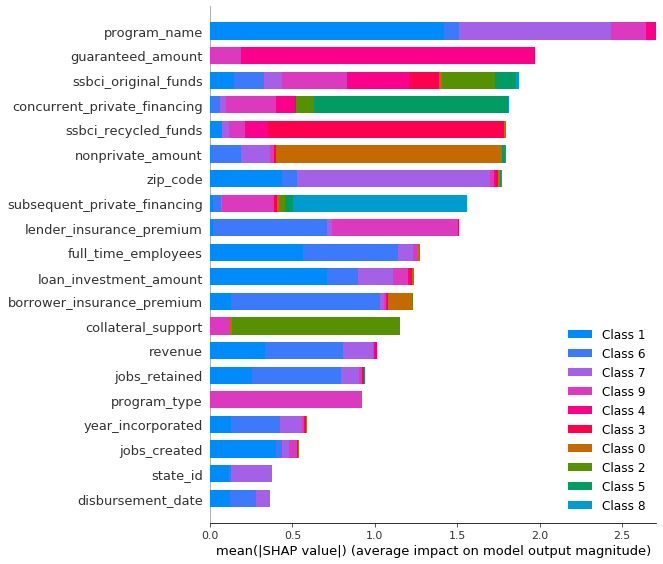

In [ ]:
clf_kp.fit(lgbm_data, clusters)
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(lgbm_data)
shap.summary_plot(shap_values_kp, lgbm_data, plot_type="bar") #plot_size=(15, 10))